In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
homedir=os.getenv('HOME')
from astropy.table import Table

#### Load NED-LVS Table, Isolate Galaxy ('G') Objtypes

In [4]:
t=Table.read(homedir+'/Desktop/wisesize/archive_tables/NEDLVS_20210922_v2.fits')

#isolating all objects with a. "galaxy" objtype
t_gal = t[t['objtype']=='G']

In [5]:
print(f"Fraction of galaxies with Mstar measurements: {len(t[~t['Mstar'].mask])/len(t):.2f}")
print(f"Fraction of galaxies with SFR(W4) measurements: {len(t[~t['SFR_W4'].mask])/len(t):.2f}")
print(f"Fraction of galaxies with SFR(W4+UV) measurements: {len(t[~t['SFR_hybrid'].mask])/len(t):.2f}")

Fraction of galaxies with Mstar measurements: 0.88
Fraction of galaxies with SFR(W4) measurements: 0.88
Fraction of galaxies with SFR(W4+UV) measurements: 0.36


#### Mass Completeness Steps

##### Summarized:
0. Apply all other 'cuts' to sample, if any. Mass completeness should come LAST.
    * sSFR, W3 S/N, size, morphology, etc. 

1. Select galaxies near z$_{max}$ = 0.025 (the upper end of our sample). Try to ensure ~400-500 galaxies in this collection.


2. From this group, select galaxies with -0.5 < m-m$_r$ < -1.0, where m$_r$ = 17.77 (SDSS apparent magnitude limit)
    * this bright subsample at the far end of our redshift distribution is far enough above the magnitude completeness limit so as to be equally complete for all r-band M/L. 


3. Compute $\Delta$m=m-m$_r$ and $\frac{L_{scale}}{L} = 10^{-0.4(-\Delta m)}$, where L$_{scale}$ is the scale luminosity. Note both luminosities are in the r-band. Then, calculate $\frac{M_{*,scale}}{M_*} = 10^{-0.4(-\Delta m)}$. 
    * we fade the galaxies and reduce their masses such that they lie at the m_r limit of our survey AND the ratios are unchanged: M/L = Mscale/Lscale
    * e.g., if the galaxy is 1 mag brighter than m_r, we reduce the stellar mass AND luminosity by a factor of 2.5. THIS is what those scaled variables do.
    * creates a synthetic pool of galaxies from this bright subsample that have the full range of M/L but are at our magnitude limit. 

4. L$_{scale}$, the luminosity of objects at apparent magnitude limit at the highest redshift limit of our sample, should be same for all galaxies in our subsample. DIFFERENT M$_{scale}$ --> we have a range of masses with ~same luminosity


5. Compute the distribution of M$_{*,scale}$ and find the upper 90th or 95th percentile --> corresponds to the ~highest M/L at $L_{scale}$
    * used the subsample to estimate how massive (M$_*$) a galaxy at our apparent magnitude limit must be in order to be detected regardless of M/L

-----

##### A Few Notes
* Without any corrections, we will only detect, close to our magnitude limit, low M/L galaxies (young stellar populations...much more luminosity for a given mass)
* THE GOAL is to find, at the upper redshift limit of our sample, the mass at and above which all M/L are visible
* Use bright subsample to estimate how massive a galaxy at our apparent magnitude limit must be in order to be detected regardless of M/L
  * To do so...calculate amount of fading required to bring each galaxy in the subsample to the magnitude limit of r=17.7
  * Then decrease the stellar masses by the same factor
  * The resulting stellar mass distribution has, by construction, identical apparent magnitudes and luminosities -- represents the intrinsic distribution in M/L (and hence in M*) for galaxies at our magnitude limit

#### Mass Completeness (for real)

##### 0. Apply any needed cuts to sample

In [61]:
# sSFR > -11.5
# S/N (W3) > 20
# SFR > [insert limit here]
# Morphology cut (before or after?)
# etc.

##### 1. Select galaxies near z$_{max}$. Try |z$_{max}$-z| < 0.05z$_{max}$.

In [65]:
z=t_gal['z']
zmax=0.025
zflag = (np.abs(zmax-z)<0.05*zmax)

In [101]:
t_gal_zflag = t_gal[zflag]

In [97]:
#m_J, Lum_J; m_W1, Lum_W1; Mstar; MLratio
#apparent magnitudes in Vega system, luminosities in erg/sec

2. From the group above, select galaxies with -0.5 < m-m$_r$ < -1.0

In [98]:
#NED-LVS does not have m_r magnitudes!
#use m_j of 16.6 for apparent magnitude limit as a test

#R-J color is 1.1 for elliptical galaxies using local templates
#so I will use 17.7 - 1.1 = 16.6 for m_j

In [118]:
m_J_lim = 16.6

m_J = t_gal_zflag['m_J']
L_J = t_gal_zflag['Lum_J']

deltam_J = m_J - m_J_lim

m_Jflag = (deltam_J<-0.5) & (deltam_J>-1.0)

t_gal_zflag_mJflag = t_gal_zflag[m_Jflag]
m_J = m_J[m_Jflag]
L_J = L_J[m_Jflag]

In [119]:
print(len(t_gal_zflag_mJflag))

583


3. Compute the scale factors, M$_{scale}$ and L$_{scale}$

In [121]:
L_scale = L_J * 10**(0.4*(m_J-m_J_lim))

In [135]:
M_scale = t_gal_zflag_mJflag['Mstar'] * 10**(0.4*(m_J-m_J_lim))

4. Arrange distribution of M$_{scale}$, find upper 90-95th percentile

In [138]:
#the ~M_scale.mask will remove any entries with no values
M_scale = np.sort(M_scale[~M_scale.mask])

In [141]:
#find 90% index 
index = int(len(M_scale)*0.9)

In [148]:
#find M_scale corresponding to this index
M_limit = np.log10(M_scale[index])

In [149]:
print(f'Mass Completeness Limit: {M_limit:.2f}')

Mass Completeness Limit: 9.30


#### Automated Steps and SFR vs. Mstar Plot

In [283]:
mag_lim = 16.6
mag = t_gal['m_J']

z=t_gal['z']
z_max=0.025

mstar = t_gal['Mstar']
sfr = t_gal['SFR_hybrid']

percentile = 0.95

In [284]:
%run mass_completeness.py

<Figure size 640x480 with 0 Axes>

Number of scaled galaxies from which to select mass limit: 523
Calculated a log(Mscale) limit of 9.49


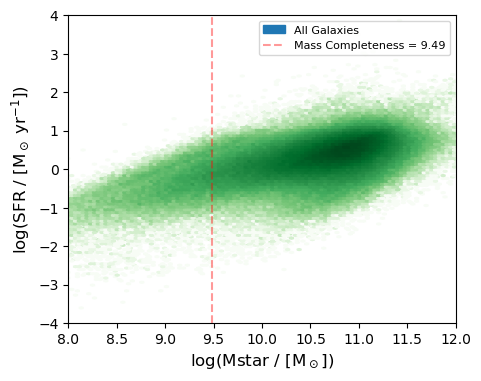

In [285]:
mass_completeness(mag, mag_lim, z, z_max, mstar, percentile, sfr=sfr, plot=True, hexbin=True, nbins=300)

#### Save mass completeness flag column to NED-LVS parent table

In [29]:
#find stellar mass column in nedlvs_parent
cat=Table.read(homedir+'/Desktop/wisesize/nedlvs_parent_v1.fits')
logmass = np.log10(t['Mstar'])

#from above
logmass_lim = 9.49

mstarflag = (logmass>=logmass_lim)

In [30]:
cat['Mstar_flag'] = mstarflag.data

In [31]:
cat.write(homedir+'/Desktop/wisesize/nedlvs_parent_v1.fits',overwrite=True)